## libraries & Loading Data

In [2]:
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler , OneHotEncoder
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import keras

In [4]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [5]:
!gdown 1fcI5NHsGkZibFxnCalRXtPsOtxmQKLuw
#https://drive.google.com/file/d/1fcI5NHsGkZibFxnCalRXtPsOtxmQKLuw/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1fcI5NHsGkZibFxnCalRXtPsOtxmQKLuw
From (redirected): https://drive.google.com/uc?id=1fcI5NHsGkZibFxnCalRXtPsOtxmQKLuw&confirm=t&uuid=0304498c-7d72-49ca-bf8e-52e2d31cf0dd
To: /content/DATA.mat
100% 2.91M/2.91M [00:00<00:00, 171MB/s]


In [7]:
# Load .mat file
DATA  = scipy.io.loadmat('DATA.mat')


info_DATA = scipy.io.whosmat('DATA.mat')


print(info_DATA)

type(DATA)


[('NOV17', (86400, 17), 'double'), ('NOV9', (86400, 17), 'double')]


dict

## info

In [18]:
# Extract the data
Data_n9 = DATA['NOV9']
df_raw =  pd.DataFrame(Data_n9)
print(df_raw.columns)
print(df_raw.describe())
print(df_raw.shape)
print(df_raw.head())
print(df_raw.isnull().sum())
print(df_raw.dtypes)
print(df_raw.info())








RangeIndex(start=0, stop=17, step=1)
                 0             1             2             3             4   \
count  86400.000000  86400.000000  86400.000000  86400.000000  86400.000000   
mean   43199.500000    665.175924    339.236698     95.670477    340.357216   
std    24941.675966     48.113068     34.694585      3.079839     39.560152   
min        0.000000    491.600000    205.600000     69.600000    198.500000   
25%    21599.750000    630.300000    307.900000     95.900000    301.800000   
50%    43199.500000    652.000000    353.600000     96.300000    359.000000   
75%    64799.250000    706.700000    365.600000     96.600000    370.800000   
max    86399.000000    812.900000    432.200000     97.800000    428.200000   

                 5             6             7             8             9   \
count  86400.000000  86400.000000  86400.000000  86400.000000  86400.000000   
mean      37.363172     36.485388     46.747105    128.365163    132.272375   
std        6.4

## train

In [26]:
import scipy.io
import pandas as pd
from imblearn.over_sampling import SMOTE

# Load .mat file
DATA = scipy.io.loadmat('DATA.mat')

info_DATA = scipy.io.whosmat('DATA.mat')

print(info_DATA)

# Extract the data
Data_n9 = DATA['NOV9']
df_raw = pd.DataFrame(Data_n9)
df = df_raw.drop(df_raw.columns[0], axis=1)

# Separate the data into normal and fault classes
normal = df.iloc[0:50000]
f16 = df.iloc[57275:57551]
f18_1 = df.iloc[58830:58931]
f18_2 = df.iloc[58520:58626]
f18 = pd.concat([f18_1, f18_2])

# Print the shapes of the classes
print("Shapes before balancing:")
print("Normal:", normal.shape)
print("Fault 16:", f16.shape)
print("Fault 18:", f18.shape)

# Combine the data for SMOTE
df_combined = pd.concat([normal, f16, f18])
labels = [0] * len(normal) + [1] * len(f16) + [2] * len(f18)

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=24)
X_resampled, y_resampled = smote.fit_resample(df_combined, labels)

# Convert the resampled data back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=df.columns)
df_resampled['label'] = y_resampled

# Print the new shapes of the classes
print("Shapes after balancing:")
print(df_resampled['label'].value_counts())

# Separate the balanced dataset back into classes if needed
normal_balanced = df_resampled[df_resampled['label'] == 0].drop('label', axis=1)
f16_balanced = df_resampled[df_resampled['label'] == 1].drop('label', axis=1)
f18_balanced = df_resampled[df_resampled['label'] == 2].drop('label', axis=1)

print("Balanced shapes:")
print("Normal:", normal_balanced.shape)
print("Fault 16:", f16_balanced.shape)
print("Fault 18:", f18_balanced.shape)


[('NOV17', (86400, 17), 'double'), ('NOV9', (86400, 17), 'double')]
Shapes before balancing:
Normal: (50000, 16)
Fault 16: (276, 16)
Fault 18: (207, 16)
Shapes after balancing:
label
0    50000
1    50000
2    50000
Name: count, dtype: int64
Balanced shapes:
Normal: (50000, 16)
Fault 16: (50000, 16)
Fault 18: (50000, 16)


##Test

## feature extraction

In [35]:
# Define function to extract random 20000 samples and reshape into 100x200 matrix
def extract_and_reshape(data, M, N, feature_count):
    total_elements = M * N
    if len(data) * feature_count < total_elements:
        raise ValueError(f"The dataset does not have enough elements to form an {M}x{N} matrix.")

    # Randomly select samples
    sampled_data = data.sample(n=total_elements // feature_count, random_state=24).reset_index(drop=True)

    # Reshape into MxN matrix
    reshaped_data = np.array(sampled_data).flatten()[:total_elements].reshape(M, N)
    return reshaped_data

M = 100
N = 200  # Desired shape
feature_count = 16  # Number of features per sample

Normal = extract_and_reshape(normal_balanced, M, N, feature_count)
Fault1 = extract_and_reshape(f16_balanced, M, N, feature_count)
Fault2 = extract_and_reshape(f18_balanced, M, N, feature_count)

print(Normal.shape, Fault1.shape, Fault2.shape)

(100, 200) (100, 200) (100, 200)


In [36]:
from scipy import stats

class FeatureExtraction:
    def __init__(self, matrix):
        self.matrix = matrix
        self.features = {
            'standard_deviation': self.standard_deviation(),
            'peak': self.peak(),
            'skewness': self.skewness(),
            'kurtosis' : self.kurtosis(),
            'crest_factor': self.crest_factor(),
            'clearance_factor' : self.clearance_factor(),
            'peak_to_peak' : self.peak_to_peak(),
            'shape_factor' : self.shape_factor(),
            'impact_factor': self.impact_factor(),
            'square_mean_root' : self.square_mean_root(),
            'mean': self.mean(),
            'absolute_mean': self.absolute_mean(),
            'root_mean_square': self.root_mean_square(),
            'impulse_factor' : self.impulse_factor()
        }

    def mean(self):
        return np.mean(self.matrix, axis=1)

    def absolute_mean(self):
        return np.mean(np.abs(self.matrix), axis=1)

    def standard_deviation(self):
        return np.std(self.matrix, axis=1)

    def peak(self):
        return np.max(self.matrix, axis=1)

    def skewness(self):
        return stats.skew(self.matrix, axis=1)

    def kurtosis(self):
        return stats.kurtosis(self.matrix, axis=1)

    def crest_factor(self):
        return self.peak() / self.root_mean_square()

    def clearance_factor(self):
        return self.peak() / np.square(self.square_mean_root())

    def peak_to_peak(self):
        return np.ptp(self.matrix, axis=1)

    def shape_factor(self):
        return self.root_mean_square() / self.absolute_mean()

    def impact_factor(self):
        return np.max(np.abs(self.matrix), axis=1) / self.absolute_mean()

    def square_mean_root(self):
        return np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1))

    def root_mean_square(self):
        return np.sqrt(np.mean(np.square(self.matrix), axis=1))

    def impulse_factor(self):
        return np.max(np.abs(self.matrix), axis=1) / np.mean(np.abs(self.matrix), axis=1)




In [ ]:

def process_datasets(normal, fault1, fault2 ):

    n_fe = FeatureExtraction(normal).features
    f_fe1 = FeatureExtraction(fault1).features
    f_fe2 = FeatureExtraction(fault2).features
    # Convert dictionaries to arrays
    normal_ar = np.array(list(n_fe.values())).T
    fault1_ar = np.array(list(f_fe1.values())).T
    fault2_ar = np.array(list(f_fe2.values())).T
    # Combine the features into a single dataset
    combined_features = np.concatenate((normal_ar,fault1_ar,fault2_ar), axis=0)

    # create labels, 0 for normal, 1 for fault
    labels = np.concatenate((np.zeros(normal_ar.shape[0]), np.ones(fault1_ar.shape[0]),
                              np.full(fault2_ar.shape[0],2)))

    return combined_features, labels

# X is combined_features
# y is Lables
X, y = process_datasets(Normal, Fault1,Fault2,Fault3)
print("Combined Features Shape:", X.shape)
print("Labels:", y.shape)


In [40]:
# Extract features for each class
normal_features = FeatureExtraction(Normal).features
fault1_features = FeatureExtraction(Fault1).features
fault2_features = FeatureExtraction(Fault2).features

# Combine features into a DataFrame
def combine_features(features, label):
    df_features = pd.DataFrame(features)
    df_features['label'] = label
    return df_features

df_normal_features = combine_features(normal_features, 'normal')
df_fault1_features = combine_features(fault1_features, 'fault1')
df_fault2_features = combine_features(fault2_features, 'fault2')

# Combine all features into one DataFrame
df_main = pd.concat([df_normal_features, df_fault1_features, df_fault2_features], ignore_index=True)

print(df_main.head())
print(df_main.shape)

   standard_deviation   peak  skewness  kurtosis  crest_factor  \
0          168.949524  747.0  1.878954  3.253162      3.163184   
1          163.877222  797.3  2.015555  3.996452      3.486845   
2          171.330068  789.0  2.108682  4.245998      3.343939   
3          164.790798  801.2  2.136460  4.554294      3.505927   
4          168.123416  726.0  1.928099  3.457156      3.094225   

   clearance_factor  peak_to_peak  shape_factor  impact_factor  \
0          0.043266         735.4      1.431239       4.527273   
1          0.049024         785.3      1.433907       4.999812   
2          0.047233         777.4      1.454426       4.863510   
3          0.049864         790.4      1.443351       5.060285   
4          0.042630         714.3      1.433608       4.435904   

   square_mean_root      mean  absolute_mean  root_mean_square  \
0        131.396859  165.0000       165.0000        236.154487   
1        127.528522  159.4660       159.4660        228.659461   
2       

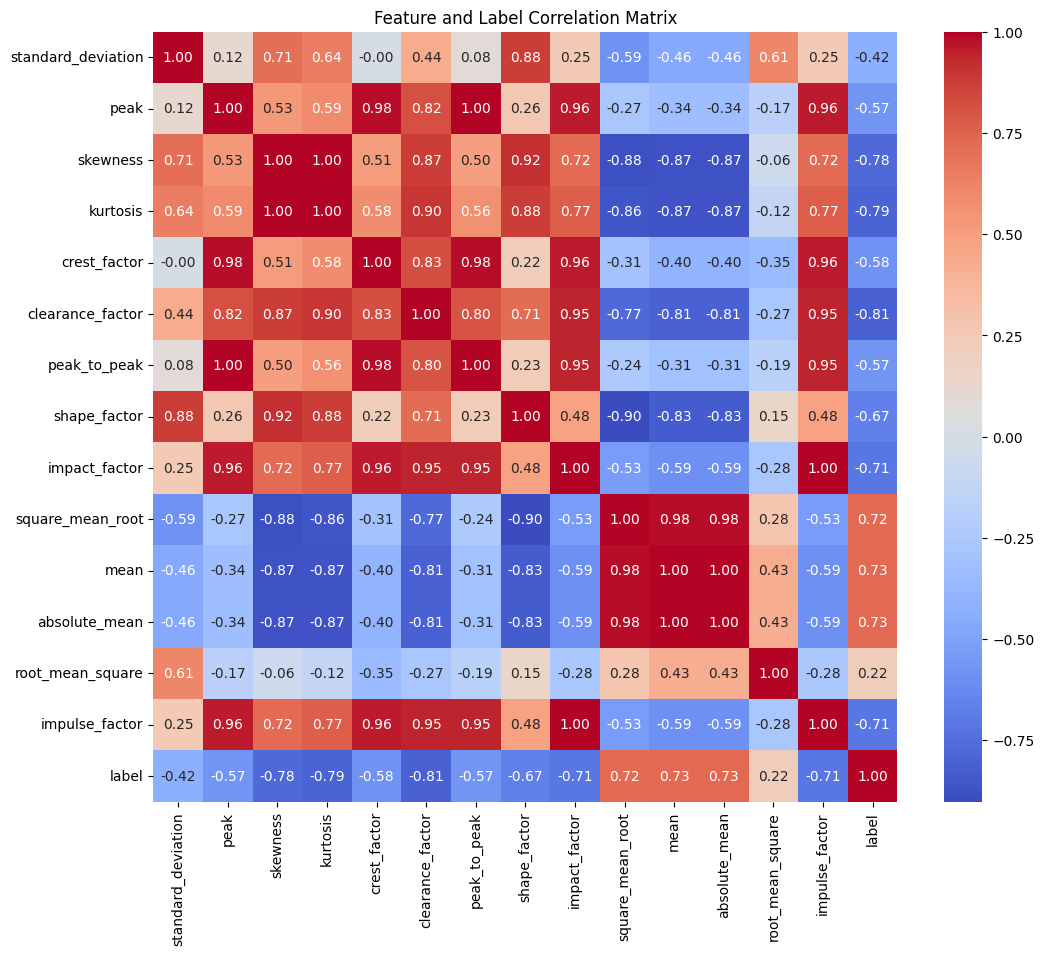

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_all_features is the combined DataFrame with features and labels

# Encode the labels to numerical values
label_mapping = {'normal': 0, 'fault1': 1, 'fault2': 2}
df_all_features['label'] = df_all_features['label'].map(label_mapping)

# Calculate the correlation matrix including the label
correlation_matrix = df_all_features.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature and Label Correlation Matrix')
plt.show()


In [47]:

# Optionally, you can identify highly correlated features and label
threshold = 0.5  # Example threshold for high correlation
high_corr_pairs = [(feature, correlation_matrix['label'][feature])
                   for feature in correlation_matrix.columns if feature != 'label' and abs(correlation_matrix['label'][feature]) > threshold]

print("Features highly correlated with the label (correlation > 0.5):")
for feature, corr_value in high_corr_pairs:
    print(f"{feature}: {corr_value:.2f}")

Features highly correlated with the label (correlation > 0.5):
peak: -0.57
skewness: -0.78
kurtosis: -0.79
crest_factor: -0.58
clearance_factor: -0.81
peak_to_peak: -0.57
shape_factor: -0.67
impact_factor: -0.71
square_mean_root: 0.72
mean: 0.73
absolute_mean: 0.73
impulse_factor: -0.71


In [52]:

# Identify features with absolute correlation with the label below 0.6
threshold = 0.6
low_corr_features = [feature for feature in correlation_matrix.columns if feature != 'label' and abs(correlation_matrix['label'][feature]) < threshold]

print(f"Features with absolute correlation with the label below {threshold}:")
print(low_corr_features)

# Drop these features from the DataFrame
df_all_features_reduced = df_all_features.drop(columns=low_corr_features)

# Proceed with the train-test split and model training using the reduced feature set
X_reduced = df_all_features_reduced.drop('label', axis=1)
y_reduced = df_all_features_reduced['label']
print(X_reduced.shape,y_reduced.shape)

Features with absolute correlation with the label below 0.6:
['standard_deviation', 'peak', 'crest_factor', 'peak_to_peak', 'root_mean_square']
(300, 9) (300,)


In [102]:
# Split the data into training and testing sets
X_train_raw, X_valid_raw, y_train_raw, y_valid_raw =train_test_split(X_reduced,y_reduced,random_state=24,test_size=0.2 , shuffle=True)
X_train_raw.shape, X_valid_raw.shape, y_train_raw.shape, y_valid_raw.shape



((240, 9), (60, 9), (240,), (60,))

In [103]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)


#MLP

In [104]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train = to_categorical(y_train_raw, num_classes=3)
y_valid = to_categorical(y_valid_raw, num_classes=3)

# Create the MLP model
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01)
, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train, y_train, epochs=30, batch_size=10, validation_data=(X_valid, y_valid))

# Evaluate the model
y_pred_prob = model.predict(X_valid)
y_pred = np.argmax(y_pred_prob, axis=1)
y_valid_labels = np.argmax(y_valid, axis=1)

accuracy = accuracy_score(y_valid_labels, y_pred)
report = classification_report(y_valid_labels, y_pred, target_names=label_mapping.keys())

print(f"MLP Accuracy: {accuracy:.2f}")
print("MLP Classification Report:")
print(report)



Epoch 1/30
24/24 [==============================] - 1s 15ms/step - loss: 0.4539 - accuracy: 0.8375 - val_loss: 0.5798 - val_accuracy: 0.7833
Epoch 2/30
24/24 [==============================] - 0s 5ms/step - loss: 0.2655 - accuracy: 0.9208 - val_loss: 0.3815 - val_accuracy: 0.8000
Epoch 3/30
24/24 [==============================] - 0s 5ms/step - loss: 0.1823 - accuracy: 0.9167 - val_loss: 0.5338 - val_accuracy: 0.8333
Epoch 4/30
24/24 [==============================] - 0s 6ms/step - loss: 0.1495 - accuracy: 0.9500 - val_loss: 0.2544 - val_accuracy: 0.8500
Epoch 5/30
24/24 [==============================] - 0s 6ms/step - loss: 0.1060 - accuracy: 0.9625 - val_loss: 0.1620 - val_accuracy: 0.9333
Epoch 6/30
24/24 [==============================] - 0s 6ms/step - loss: 0.0777 - accuracy: 0.9792 - val_loss: 0.1422 - val_accuracy: 0.9333
Epoch 7/30
24/24 [==============================] - 0s 5ms/step - loss: 0.0581 - accuracy: 0.9958 - val_loss: 0.0843 - val_accuracy: 0.9667
Epoch 8/30
24/24 [=

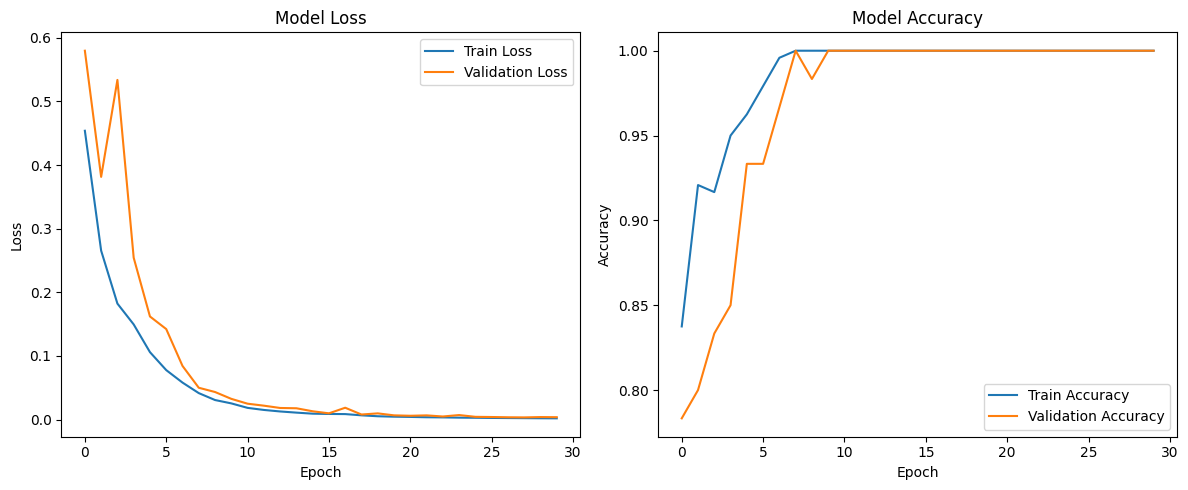

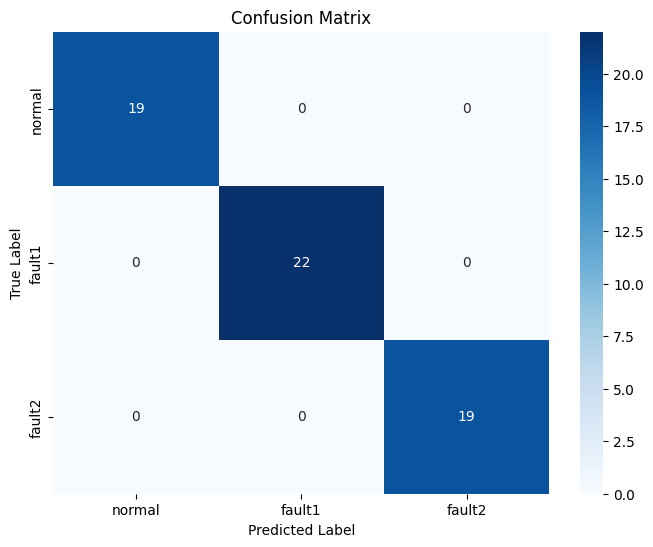

In [105]:

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_valid_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'fault1', 'fault2'], yticklabels=['normal', 'fault1', 'fault2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Kfold

Features with absolute correlation with the label below 0.6:
['standard_deviation', 'peak', 'crest_factor', 'peak_to_peak', 'root_mean_square']
2/2 [==============================] - 0s 5ms/step
Fold 1 - Accuracy: 1.00
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        22
      fault1       1.00      1.00      1.00        16
      fault2       1.00      1.00      1.00        22

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



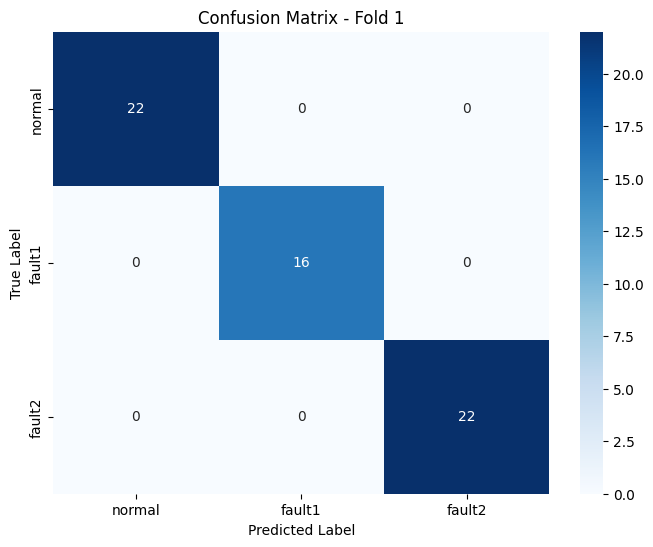

2/2 [==============================] - 0s 7ms/step
Fold 2 - Accuracy: 1.00
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        22
      fault1       1.00      1.00      1.00        23
      fault2       1.00      1.00      1.00        15

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



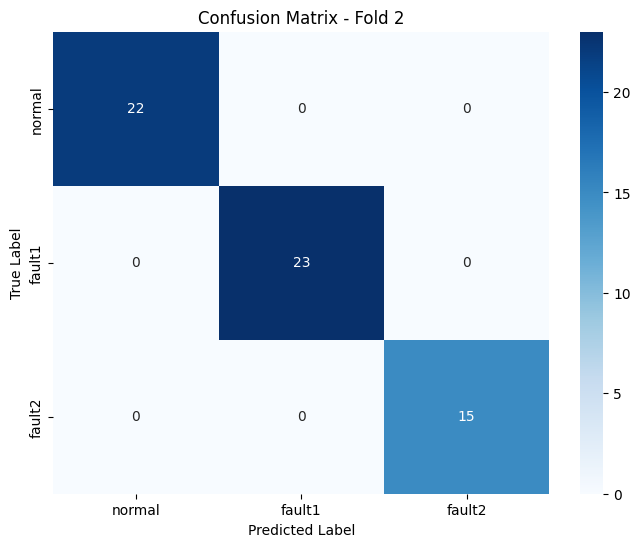

2/2 [==============================] - 0s 5ms/step
Fold 3 - Accuracy: 1.00
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        16
      fault1       1.00      1.00      1.00        26
      fault2       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



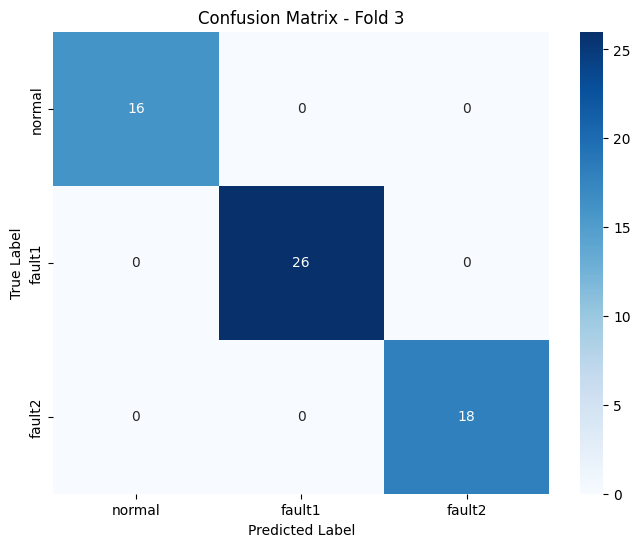

2/2 [==============================] - 0s 5ms/step
Fold 4 - Accuracy: 1.00
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        20
      fault1       1.00      1.00      1.00        13
      fault2       1.00      1.00      1.00        27

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



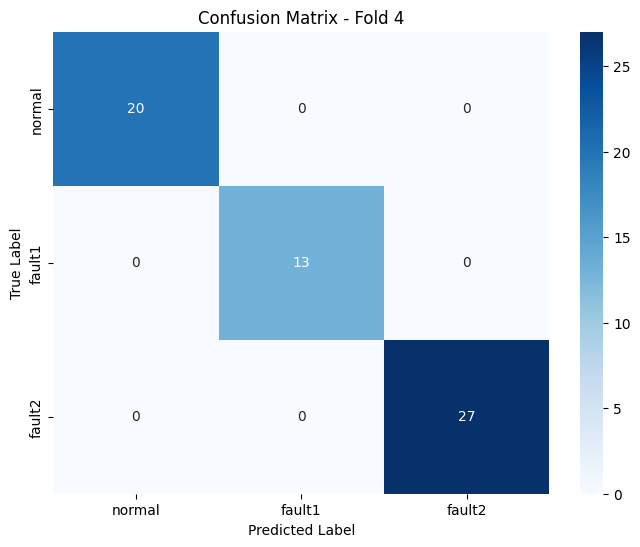

2/2 [==============================] - 0s 9ms/step
Fold 5 - Accuracy: 1.00
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        20
      fault1       1.00      1.00      1.00        22
      fault2       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



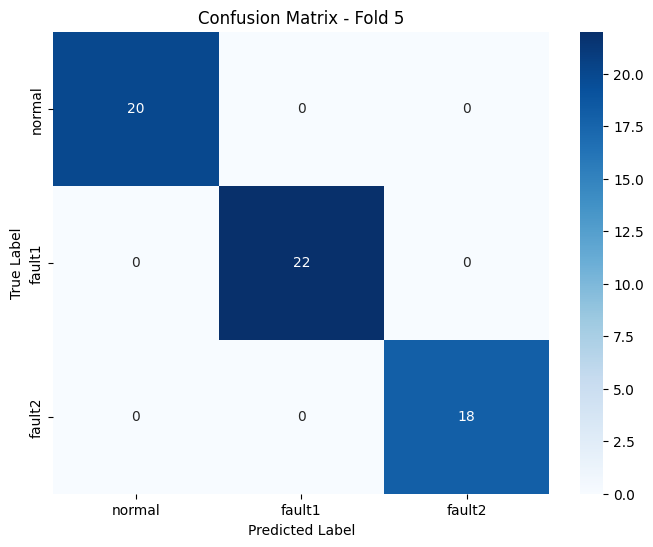

Mean Accuracy: 1.00


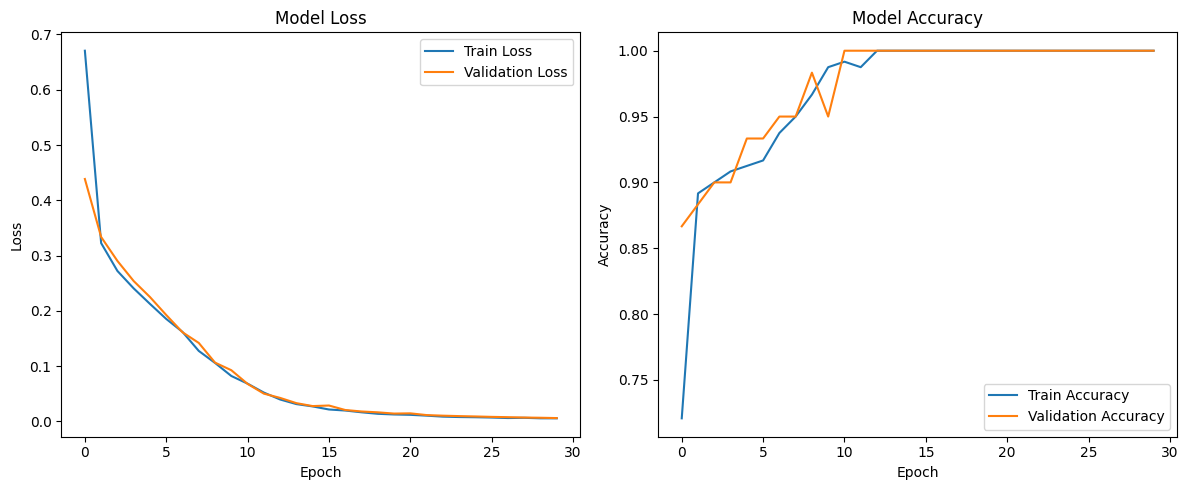

In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_all_features and correlation_matrix are already defined
# Identify features with absolute correlation with the label below 0.6
threshold = 0.6
low_corr_features = [feature for feature in correlation_matrix.columns if feature != 'label' and abs(correlation_matrix['label'][feature]) < threshold]

print(f"Features with absolute correlation with the label below {threshold}:")
print(low_corr_features)

# Drop these features from the DataFrame
df_all_features_reduced = df_all_features.drop(columns=low_corr_features)

# Prepare features and labels
X = df_all_features_reduced.drop('label', axis=1)
y = df_all_features_reduced['label']
y = to_categorical(y, num_classes=3)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the MLP model creation function
def create_mlp(input_dim):
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
fold = 1

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the model
    model = create_mlp(X_train.shape[1])
    history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_labels, y_pred)
    accuracies.append(accuracy)

    print(f"Fold {fold} - Accuracy: {accuracy:.2f}")
    print(classification_report(y_test_labels, y_pred, target_names=['normal', 'fault1', 'fault2']))

    # Plotting the confusion matrix for each fold
    conf_matrix = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'fault1', 'fault2'], yticklabels=['normal', 'fault1', 'fault2'])
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    fold += 1

# Print the mean accuracy across all folds
print(f"Mean Accuracy: {np.mean(accuracies):.2f}")

# Plotting loss and accuracy for the last fold
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test data

In [77]:
# Load the new test dataset
Data_n17 = scipy.io.loadmat('DATA.mat')['NOV17']
df_test = pd.DataFrame(Data_n17)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       86400 non-null  float64
 1   1       86400 non-null  float64
 2   2       86400 non-null  float64
 3   3       86400 non-null  float64
 4   4       86400 non-null  float64
 5   5       86400 non-null  float64
 6   6       86400 non-null  float64
 7   7       86400 non-null  float64
 8   8       86400 non-null  float64
 9   9       86400 non-null  float64
 10  10      86400 non-null  float64
 11  11      86400 non-null  float64
 12  12      86400 non-null  float64
 13  13      86400 non-null  float64
 14  14      86400 non-null  float64
 15  15      86400 non-null  float64
 16  16      86400 non-null  float64
dtypes: float64(17)
memory usage: 11.2 MB
None


In [106]:
import scipy.io
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from scipy import stats

# Load .mat file
DATA = scipy.io.loadmat('DATA.mat')

# Extract the data
Data_n9 = DATA['NOV9']
df_raw = pd.DataFrame(Data_n9)
df = df_raw.drop(df_raw.columns[0], axis=1)

# Separate the data into normal and fault classes
normal = df.iloc[0:50000]
f16_test = df.iloc[56670:56770]
f18_test = df.iloc[54600:54700]

# Print the shapes of the classes
print("Shapes before balancing:")
print("Normal:", normal.shape)
print("Fault 16:", f16.shape)
print("Fault 18:", f18.shape)

# Combine the data for SMOTE
df_combined = pd.concat([normal, f16, f18])
labels = [0] * len(normal) + [1] * len(f16) + [2] * len(f18)

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=24)
X_test_r


Shapes before balancing:
Normal: (50000, 16)
Fault 16: (276, 16)
Fault 18: (207, 16)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,699.100000,300.600000,97.8,296.200000,42.700000,42.000000,46.100000,129.100000,133.400000,12.2,26.400000,53.000000,242.000000,136.900000,164.000000,132.10000
1,697.700000,298.900000,97.8,295.400000,41.800000,41.600000,45.300000,129.100000,133.300000,12.2,26.400000,51.600000,241.400000,136.900000,164.100000,132.10000
2,696.200000,301.800000,97.8,295.400000,42.900000,41.400000,46.600000,129.100000,133.400000,12.2,26.300000,50.300000,241.600000,136.900000,164.100000,132.10000
3,702.800000,300.900000,97.7,295.100000,43.100000,41.500000,46.000000,129.100000,133.400000,12.2,26.200000,50.200000,241.600000,136.900000,164.200000,132.10000
4,701.300000,292.600000,97.8,294.600000,42.600000,42.300000,47.000000,129.100000,133.400000,12.2,26.100000,51.800000,241.300000,136.800000,163.900000,132.10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,602.900000,401.209396,96.3,399.603759,49.496868,47.992483,55.798121,128.400000,132.699374,13.4,21.401253,68.689977,271.398747,140.000626,169.400626,133.10000
149996,587.429691,412.381948,96.3,407.572090,42.660332,41.760332,52.001781,128.400000,132.236936,13.4,21.826128,68.641449,272.541449,140.200000,170.152257,133.20000
149997,618.413256,374.150679,96.3,387.061013,36.871346,35.822808,49.606628,127.900000,131.800000,13.4,21.200000,68.977974,272.874269,140.000000,168.516179,132.85809
149998,646.944457,359.241516,96.3,363.130996,43.413462,41.658484,51.992987,127.965498,132.365498,13.4,21.627489,70.227489,273.134502,140.034502,168.865498,132.90000


## test

In [110]:
import scipy.io
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from scipy import stats

# Load .mat file
DATA = scipy.io.loadmat('DATA.mat')

# Extract the data
Data_n9 = DATA['NOV9']
df_raw = pd.DataFrame(Data_n9)
df = df_raw.drop(df_raw.columns[0], axis=1)

# Separate the data into normal and fault classes
normal = df.iloc[0:50000]
f16 = df.iloc[56670:56770]
f18 = df.iloc[54600:54700]
#f16_test = df.iloc[56670:56770]
#f18_test = df.iloc[54600:54700]
# Print the shapes of the classes
print("Shapes before balancing:")
print("Normal:", normal.shape)
print("Fault 16:", f16.shape)
print("Fault 18:", f18.shape)

# Combine the data for SMOTE
df_combined = pd.concat([normal, f16, f18])
labels = [0] * len(normal) + [1] * len(f16) + [2] * len(f18)

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=24)
X_resampled, y_resampled = smote.fit_resample(df_combined, labels)

# Convert the resampled data back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=df.columns)
df_resampled['label'] = y_resampled

# Print the new shapes of the classes
print("Shapes after balancing:")
print(df_resampled['label'].value_counts())

# Separate the balanced dataset back into classes if needed
normal_balanced = df_resampled[df_resampled['label'] == 0].drop('label', axis=1)
f16_balanced = df_resampled[df_resampled['label'] == 1].drop('label', axis=1)
f18_balanced = df_resampled[df_resampled['label'] == 2].drop('label', axis=1)

print("Balanced shapes:")
print("Normal:", normal_balanced.shape)
print("Fault 16:", f16_balanced.shape)
print("Fault 18:", f18_balanced.shape)

# Define function to extract random 20000 samples and reshape into 100x200 matrix
def extract_and_reshape(data, M, N, feature_count):
    total_elements = M * N
    if len(data) * feature_count < total_elements:
        raise ValueError(f"The dataset does not have enough elements to form an {M}x{N} matrix.")

    # Randomly select samples
    sampled_data = data.sample(n=total_elements // feature_count, random_state=24).reset_index(drop=True)

    # Reshape into MxN matrix
    reshaped_data = np.array(sampled_data).flatten()[:total_elements].reshape(M, N)
    return reshaped_data

M = 100
N = 200  # Desired shape
feature_count = 16  # Number of features per sample

Normal = extract_and_reshape(normal_balanced, M, N, feature_count)
Fault1 = extract_and_reshape(f16_balanced, M, N, feature_count)
Fault2 = extract_and_reshape(f18_balanced, M, N, feature_count)

print(Normal.shape, Fault1.shape, Fault2.shape)

class FeatureExtraction:
    def __init__(self, matrix):
        self.matrix = matrix
        self.features = {
            'standard_deviation': self.standard_deviation(),
            'peak': self.peak(),
            'skewness': self.skewness(),
            'kurtosis' : self.kurtosis(),
            'crest_factor': self.crest_factor(),
            'clearance_factor' : self.clearance_factor(),
            'peak_to_peak' : self.peak_to_peak(),
            'shape_factor' : self.shape_factor(),
            'impact_factor': self.impact_factor(),
            'square_mean_root' : self.square_mean_root(),
            'mean': self.mean(),
            'absolute_mean': self.absolute_mean(),
            'root_mean_square': self.root_mean_square(),
            'impulse_factor' : self.impulse_factor()
        }

    def mean(self):
        return np.mean(self.matrix, axis=1)

    def absolute_mean(self):
        return np.mean(np.abs(self.matrix), axis=1)

    def standard_deviation(self):
        return np.std(self.matrix, axis=1)

    def peak(self):
        return np.max(self.matrix, axis=1)

    def skewness(self):
        return stats.skew(self.matrix, axis=1)

    def kurtosis(self):
        return stats.kurtosis(self.matrix, axis=1)

    def crest_factor(self):
        return self.peak() / self.root_mean_square()

    def clearance_factor(self):
        return self.peak() / np.square(self.square_mean_root())

    def peak_to_peak(self):
        return np.ptp(self.matrix, axis=1)

    def shape_factor(self):
        return self.root_mean_square() / self.absolute_mean()

    def impact_factor(self):
        return np.max(np.abs(self.matrix), axis=1) / self.absolute_mean()

    def square_mean_root(self):
        return np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1))

    def root_mean_square(self):
        return np.sqrt(np.mean(np.square(self.matrix), axis=1))

    def impulse_factor(self):
        return np.max(np.abs(self.matrix), axis=1) / np.mean(np.abs(self.matrix), axis=1)

def process_datasets(normal, fault1, fault2):
    n_fe = FeatureExtraction(normal).features
    f_fe1 = FeatureExtraction(fault1).features
    f_fe2 = FeatureExtraction(fault2).features
    # Convert dictionaries to arrays
    normal_ar = np.array(list(n_fe.values())).T
    fault1_ar = np.array(list(f_fe1.values())).T
    fault2_ar = np.array(list(f_fe2.values())).T
    # Combine the features into a single dataset
    combined_features = np.concatenate((normal_ar, fault1_ar, fault2_ar), axis=0)

    # create labels, 0 for normal, 1 for fault 16, 2 for fault 18
    labels = np.concatenate((np.zeros(normal_ar.shape[0]), np.ones(fault1_ar.shape[0]),
                              np.full(fault2_ar.shape[0], 2)))

    return combined_features, labels

# X is combined_features
# y is Labels
X, y = process_datasets(Normal, Fault1, Fault2)
print("Combined Features Shape:", X.shape)
print("Labels:", y.shape)

# Extract features for each class
normal_features = FeatureExtraction(Normal).features
fault1_features = FeatureExtraction(Fault1).features
fault2_features = FeatureExtraction(Fault2).features

# Combine features into a DataFrame
def combine_features(features, label):
    df_features = pd.DataFrame(features)
    df_features['label'] = label
    return df_features

df_normal_features = combine_features(normal_features, 'normal')
df_fault1_features = combine_features(fault1_features, 'fault1')
df_fault2_features = combine_features(fault2_features, 'fault2')

# Combine all features into one DataFrame
df_main_test = pd.concat([df_normal_features, df_fault1_features, df_fault2_features], ignore_index=True)

print(df_main.head())
print(df_main_test.shape)


Shapes before balancing:
Normal: (50000, 16)
Fault 16: (100, 16)
Fault 18: (100, 16)
Shapes after balancing:
label
0    50000
1    50000
2    50000
Name: count, dtype: int64
Balanced shapes:
Normal: (50000, 16)
Fault 16: (50000, 16)
Fault 18: (50000, 16)
(100, 200) (100, 200) (100, 200)
Combined Features Shape: (300, 14)
Labels: (300,)
   standard_deviation   peak  skewness  kurtosis  crest_factor  \
0          168.949524  747.0  1.878954  3.253162      3.163184   
1          163.877222  797.3  2.015555  3.996452      3.486845   
2          171.330068  789.0  2.108682  4.245998      3.343939   
3          164.790798  801.2  2.136460  4.554294      3.505927   
4          168.123416  726.0  1.928099  3.457156      3.094225   

   clearance_factor  peak_to_peak  shape_factor  impact_factor  \
0          0.043266         735.4      1.431239       4.527273   
1          0.049024         785.3      1.433907       4.999812   
2          0.047233         777.4      1.454426       4.863510   
3

In [108]:
df_main_test

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_valid_labels = np.argmax(y_valid, axis=1)

accuracy = accuracy_score(y_valid_labels, y_pred)
report = classification_report(y_valid_labels, y_pred, target_names=label_mapping.keys())

print(f"MLP Accuracy: {accuracy:.2f}")
print("MLP Classification Report:")
print(report)


In [ ]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_valid_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'fault1', 'fault2'], yticklabels=['normal', 'fault1', 'fault2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()